In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torchvision
from tqdm import tqdm
import copy
from google.colab import files
import pickle

In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = (16, 9)
fontsize = 32
matplotlib.rcParams.update({'font.size': fontsize})
from matplotlib.pyplot import figure

In [3]:
criterion = nn.CrossEntropyLoss() # supervised classification loss
criterion_nonreduced = nn.CrossEntropyLoss(reduce=False) # supervised classification loss

/usr/local/lib/python3.9/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [4]:
!nvidia-smi

Wed May 17 07:24:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!mkdir sgd_images

mkdir: cannot create directory ‘sgd_images’: File exists


# Set-Up

In [6]:
# LENET parameters
RANDOM_SEED = 214748365
LEARNING_RATE = 0.001 #0.0001 for MLP
SUBSET_SIZE = 8000
TEST_SUBSET_SIZE = 10000
N_ITERS = 2001
BATCH_SIZE_HUGE = 1000
BATCH_SIZE_SMALL = 40
BATCH_SIZE_BIG = 100
BATCH_SIZE_TEST = 1000

EVAL = True

IMG_SIZE = 32
N_CLASSES = 10

#Set to zero to disconnect L2. 
weight_decay = 0.1

model_name = "inception"

In [7]:
use_cifar = True
use_mnist = False

In [8]:
from torchvision.models import resnet50

def createmodel(dropout):
  torch.cuda.manual_seed(RANDOM_SEED)
  torch.manual_seed(RANDOM_SEED)
  if model_name == "inception":
    return InceptionNet(10, train_dataset[0][0].shape[0], dropout=dropout)
  if model_name == "lenet":
    return LeNet5(10, train_dataset[0][0].shape[0], dropout=dropout)
  if model_name == "alexnet":
    return AlexNet(10, train_dataset[0][0].shape[0], dropout=dropout)
  if model_name == "mlp":
    return MLP(728,512,10, dropout=dropout)

# Data

In [9]:
# setup devices
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.manual_seed(RANDOM_SEED)
else:
    device = torch.device("cpu")

transforms = torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)),
                                 torchvision.transforms.ToTensor()])

In [10]:
!nvidia-smi

Wed May 17 07:24:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    43W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:

if use_mnist:
    train_dataset = datasets.MNIST(root='mnist_data', 
                                train=True, 
                                transform=transforms,
                                download=True)

    test_dataset = datasets.MNIST(root='mnist_data', 
                                train=False, 
                                transform=transforms)



In [12]:
if use_cifar:
    train_dataset = datasets.CIFAR10(root='cifar_data', 
                                train=True, 
                                transform=transforms,
                                download=True)

    test_dataset = datasets.CIFAR10(root='cifar_data', 
                                train=False, 
                                transform=transforms)


Files already downloaded and verified


In [13]:
train_dataset = torch.utils.data.Subset(train_dataset, list(range(0, SUBSET_SIZE)))

test_dataset = torch.utils.data.Subset(test_dataset, list(range(0, TEST_SUBSET_SIZE)))

test_loader_batch = torch.utils.data.DataLoader(dataset=test_dataset, 
                          batch_size=BATCH_SIZE_TEST, 
                          shuffle=False)

train_loader_batch = torch.utils.data.DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE_TEST, 
                          shuffle=False)

In [14]:
def moving_average(a, n=3):
    border = np.floor(n/2).astype(int)
    new_a = np.zeros(len(a) + 2*border)
    new_a[:border] = a[0]
    new_a[-border:] = a[-1]
    new_a[border:-border] = a
    ret = np.cumsum(new_a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# Model

In [15]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, n_channels, dropout = 0.0):
        super(LeNet5, self).__init__()
        torch.manual_seed(0)
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=n_channels, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout, inplace=True),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Dropout(p=dropout, inplace=True),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

In [16]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout = 0.0):
        super(MLP, self).__init__()
        torch.manual_seed(0)
        self.dropout_value = dropout
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.layer4 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.flatten(x)
        x = nn.Dropout(p=self.dropout_value)(x),
        x = self.activation(self.layer1(x))
        x = nn.Dropout(p=self.dropout_value)(x),
        x = self.activation(self.layer2(x))
        x = nn.Dropout(p=self.dropout_value)(x),
        x = self.activation(self.layer3(x))
        x = nn.Dropout(p=self.dropout_value)(x),
        x = self.layer4(x)
        return x


In [17]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x
 
class InceptionModule(nn.Module):
    
    def __init__(self, in_channels, f_1x1, f_3x3):
        super(InceptionModule, self).__init__()
        
        self.branch1 = nn.Sequential(
            ConvModule(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )
        
        self.branch2 = nn.Sequential(
            ConvModule(in_channels, f_3x3, kernel_size=3, stride=1, padding=1)
        )
                
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)


class DownsampleModule(nn.Module):
    def __init__(self, in_channels, f_3x3):
        super(DownsampleModule, self).__init__()
    
        self.branch1 = nn.Sequential(ConvModule(in_channels, f_3x3, kernel_size=3, stride=2, padding=0))
        self.branch2 = nn.MaxPool2d(3, stride=2)
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)
   
class InceptionNet(nn.Module):
    def __init__(self, num_classes, input_channels, dropout = 0.0):
        super().__init__()
        
        self.dropout_value = dropout
        self.conv1 = ConvModule(in_channels =input_channels,out_channels=96, kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96,f_1x1=32,f_3x3=32)
        self.inception2 = InceptionModule(in_channels=64,f_1x1=32,f_3x3=48)
        self.down1 = DownsampleModule(in_channels=80,f_3x3=80)
        self.inception3 = InceptionModule(in_channels=160,f_1x1=112,f_3x3=48)
        self.inception4 = InceptionModule(in_channels=160,f_1x1=96,f_3x3=64)
        self.inception5 = InceptionModule(in_channels=160,f_1x1=80,f_3x3=80)
        self.inception6 = InceptionModule(in_channels=160,f_1x1=48,f_3x3=96)   
        self.down2 = DownsampleModule(in_channels=144,f_3x3=96)
        self.inception7 = InceptionModule(in_channels=240,f_1x1=176,f_3x3=160)
        self.inception8 = InceptionModule(in_channels=336,f_1x1=176,f_3x3=160)
        self.meanpool = nn.AdaptiveAvgPool2d((7,7))
        self.fc = nn.Linear(16464, num_classes)
        self.dropout_f = nn.Dropout(p=self.dropout_value, inplace = False)
       
    def forward(self, x):
        x = self.dropout_f(x)
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.down1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.down2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.meanpool(x)
        x = torch.flatten(x,1)
        x = self.dropout_f(x)
        x = self.fc(x)
        return x

In [18]:
class AlexNet(nn.Module):

    def __init__(self, num_classes, input_channels, dropout = 0.0):
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 192, kernel_size=5, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(192),

            nn.Conv2d(192, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(256),
            
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout, inplace=True),
            nn.Linear(256, 384),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout, inplace=True),
            nn.Linear(384, 192),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout, inplace=True),
            nn.Linear(192, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1)
        return self.classifier(x)

# Code

In [19]:
def get_log_p(device, model, loader):
    cce = nn.CrossEntropyLoss(reduction = "none") # supervised classification loss
    model.eval()
    aux = []
    with torch.no_grad():
      for data, targets in loader:
          data = data.to(device)
          targets = targets.to(device)
          logits = model(data)
          probs = F.softmax(logits, dim=1)
          log_p = -cce(logits, targets) # supervised loss
          aux.append(log_p)
    return torch.cat(aux)

In [20]:
#Binary Search for lambdas
def rate_function_BS(model, s_value):
  if (s_value<0):
    min_lamb=torch.tensor(-10000).to(device)
    max_lamb=torch.tensor(0).to(device)
  else:
    min_lamb=torch.tensor(0).to(device)
    max_lamb=torch.tensor(10000).to(device)

  s_value=torch.tensor(s_value).to(device)
  log_p = get_log_p(device, model, test_loader_batch)
  return aux_rate_function_TernarySearch(log_p, s_value, min_lamb, max_lamb, 0.001)

def eval_log_p(log_p, lamb, s_value):
  jensen_val=(torch.logsumexp(lamb * log_p, 0) - torch.log(torch.tensor(log_p.shape[0], device = device)) - lamb *torch.mean(log_p))
  return lamb*s_value - jensen_val

def aux_rate_function_BinarySearch(log_p, s_value, low, high, epsilon):
  
  while (high - low) > epsilon:
      mid = (low + high) / 2
      print(mid)
      print(eval_log_p(log_p, low, s_value))
      print(eval_log_p(log_p, mid, s_value))
      print(eval_log_p(log_p, high, s_value))
      print("--")
      if eval_log_p(log_p, mid, s_value) < eval_log_p(log_p, high, s_value):
          low = mid
      else:
          high = mid

  # Return the midpoint of the final range
  mid = (low + high) / 2
  return [eval_log_p(log_p, mid, s_value).detach().cpu().numpy(), mid.detach().cpu().numpy(), (mid*s_value - eval_log_p(log_p, mid, s_value)).detach().cpu().numpy()]


def aux_rate_function_TernarySearch(log_p, s_value, low, high, epsilon):

  while (high - low) > epsilon:
    mid1 = low + (high - low) / 3
    mid2 = high - (high - low) / 3

    if eval_log_p(log_p, mid1, s_value) < eval_log_p(log_p, mid2, s_value):
        low = mid1
    else:
        high = mid2

  # Return the midpoint of the final range
  mid = (low + high) / 2
  return [eval_log_p(log_p, mid, s_value).detach().cpu().numpy(), mid.detach().cpu().numpy(), (mid*s_value - eval_log_p(log_p, mid, s_value)).detach().cpu().numpy()]

import math
def aux_rate_function_golden_section_search(log_p, s_value, a, b, epsilon):
    """
    Maximizes a univariate function using the golden section search algorithm.

    Parameters:
        f (function): The function to minimize.
        a (float): The left endpoint of the initial search interval.
        b (float): The right endpoint of the initial search interval.
        tol (float): The error tolerance value.

    Returns:
        float: The x-value that minimizes the function f.
    """
    # Define the golden ratio
    golden_ratio = (torch.sqrt(torch.tensor(5).to(device)) - 1) / 2

    # Define the initial points
    c = b - golden_ratio * (b - a)
    d = a + golden_ratio * (b - a)

    # Loop until the interval is small enough
    while abs(c - d) > epsilon:
        # Compute the function values at the new points
        fc = eval_log_p(log_p, c, s_value)
        fd = eval_log_p(log_p, d, s_value)

        # Update the interval based on the function values
        if fc > fd:
            b = d
            d = c
            c = b - golden_ratio * (b - a)
        else:
            a = c
            c = d
            d = a + golden_ratio * (b - a)

    # Return the midpoint of the final interval
    mid = (a + b) / 2
    return [eval_log_p(log_p, mid, s_value).detach().cpu().numpy(), mid.detach().cpu().numpy(), (mid*s_value - eval_log_p(log_p, mid, s_value)).detach().cpu().numpy()]


In [21]:
def eval_jensen(model, lambdas):
  log_p = get_log_p(device, model, test_loader_batch)
  return np.array(
      [
          (torch.logsumexp(lamb * log_p, 0) - torch.log(torch.tensor(log_p.shape[0], device = device)) - torch.mean(lamb * log_p)).detach().cpu().numpy() for lamb in lambdas
       ])

def inverse_rate_function(model, lambdas, rate_vals):
  jensen_vals = eval_jensen(model, lambdas)

  return np.array([ np.min((jensen_vals + rate)/lambdas) for rate in rate_vals])


In [22]:
def eval(device, model, loader, criterion):
    correct = 0
    total = 0 
    losses = []
    model.eval()
    with torch.no_grad():
        for data, targets in loader:
            total += targets.size(0)
            data = data.to(device)
            targets = targets.to(device)
            logits = model(data)
            probs = F.softmax(logits, dim=1)
            predicted = torch.argmax(probs, 1)
            correct += (predicted == targets).sum().detach().cpu().numpy()

            loss = criterion(logits, targets) # supervised loss
            losses.append(loss.detach().cpu().numpy())
      
    return correct, total, np.mean(losses), np.var(losses)

In [23]:
SKIP=False
lambdas = np.arange(-10, 10, 0.01)

def train(model, train_loader, SKIP=0, weight_decay=0, n_evals = 1):

    test_loss = []
    train_loss = []
    batch_loss = []
    variance = []
    models = []

    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
    #optimizer = optim.Adam(model.parameters(), lr=1e-3)
    data_iter = iter(train_loader)

    tq = tqdm(range(N_ITERS))
    for it in tq:

            model.train()

            try:
                inputs, target = next(data_iter)
            except StopIteration:
                # StopIteration is thrown if dataset ends
                # reinitialize data loader
                data_iter = iter(train_loader)
                inputs, target = next(data_iter)

            inputs = inputs.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            logits = model(inputs) # forward pass

            loss = criterion(logits, target) # supervised loss
            loss_aux = loss.detach().cpu().numpy()


            if it % n_evals == 0 and EVAL == True:

                batch_loss.append(loss_aux)
                _, _, eval_loss, _ = eval(
                    device, model, train_loader_batch, criterion_nonreduced
                )
                train_loss.append(eval_loss)

                
                _, _, eval_loss, var = eval(
                    device, model, test_loader_batch, criterion_nonreduced
                )
                test_loss.append(eval_loss)
                variance.append(var)

                new_model = copy.deepcopy(model).to("cpu")
                new_model.load_state_dict(model.state_dict())
                models.append(new_model)

                alpha = inputs.shape[0]*(np.abs(rate_function_BS(model, test_loss[-1]-loss_aux)[0]))



            if weight_decay>0:
              # Add L2 regularization to the loss
              l2_reg = torch.tensor(0.).to(device)
              for param in model.parameters():
                  l2_reg += torch.norm(param)
              loss += weight_decay * l2_reg
            
            if SKIP==0:
              loss.backward() # computes gradients
              optimizer.step()
            elif SKIP==1 and np.random.uniform(0,1,1) < np.exp(-alpha):
              loss.backward() # computes gradients
              optimizer.step()
            elif SKIP==2 and alpha < np.log(1.0/0.01):
              loss.backward() # computes gradients
              optimizer.step()
            
            tq.set_postfix({'loss': loss.detach().cpu().numpy(), 'eval loss': eval_loss})


            #if train_loss[-1]<0.05:
            #  break

    return np.array(batch_loss), np.array(train_loss), np.array(test_loss), np.array(variance), models

# Training

In [24]:
dropouts = [0.0, 0.0, 0.0, 0.0]

models = [createmodel(dropout = dropouts[i]).to(device) for i in range(4)]
batches = [SUBSET_SIZE, BATCH_SIZE_HUGE, BATCH_SIZE_BIG, BATCH_SIZE_SMALL]
loader = []
for size in batches:
  g_cuda = torch.Generator(device="cpu")
  g_cuda.manual_seed(RANDOM_SEED)
  loader.append(torch.utils.data.DataLoader(dataset=train_dataset, 
                          batch_size=size,
                          generator=g_cuda, 
                          shuffle=True))
skips = [0, 0, 0, 0]
n_evals = [20, 20, 20, 20]
weight_decays = [0.0, 0.0, 0.0, 0.0]
labels = ["GD", "SGD-"+str(BATCH_SIZE_HUGE), "SGD-"+str(BATCH_SIZE_BIG), "SGD-"+str(BATCH_SIZE_SMALL)]


In [25]:
print("Number of parameters: ", sum(p.numel() for p in models[0].parameters() if p.requires_grad))

Number of parameters:  1814106


In [26]:
markers = {
    "GD": 8,
    "SGD-"+str(BATCH_SIZE_HUGE): 9,
    "SGD-"+str(BATCH_SIZE_SMALL): 10,
    "SGD-"+str(BATCH_SIZE_BIG): 11,
}

In [27]:
jet = plt.cm.get_cmap('Dark2')
colors = {
    "GD": jet(0),
    "SGD-"+str(BATCH_SIZE_HUGE): jet(1),
    "SGD-"+str(BATCH_SIZE_SMALL): jet(2),
    "SGD-"+str(BATCH_SIZE_BIG): jet(3),
}

<ipython-input-27-c361740cef41>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap('Dark2')


In [ ]:
for i in range(3, 4):
  setting_name=f"rs_{RANDOM_SEED}_{model_name}_{labels[i]}_lr_{LEARNING_RATE}_trainsize_{SUBSET_SIZE}_testsize_{TEST_SUBSET_SIZE}_niters_{N_ITERS}_batchsize_{batches[i]}_wd_{weight_decay}" 
  results = train(models[i], loader[i], skips[i], weight_decay=weight_decays[i], n_evals = n_evals[i])
  with open(f'sgd_images/{setting_name}_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 2001/2001 [10:56<00:00,  3.05it/s, loss=0.017555604, eval loss=1.07]


In [32]:
BATCH_LOSS=0
TRAIN_LOSS=1
TEST_LOSS=2
VARIANCE=3
MODELS=4
train_loss = [TRAIN_LOSS, BATCH_LOSS, BATCH_LOSS, BATCH_LOSS] 

# Figure 1: Train & Test Evolution

In [28]:
models_id = [0,2,3]

In [29]:
results = []
for i in range(len(models)):
    setting_name=f"rs_{RANDOM_SEED}_{model_name}_{labels[i]}_lr_{LEARNING_RATE}_trainsize_{SUBSET_SIZE}_testsize_{TEST_SUBSET_SIZE}_niters_{N_ITERS}_batchsize_{batches[i]}_wd_{weight_decay}" 
    with open(f"sgd_images/{setting_name}_results.pickle", "rb") as handle:
      results.append(pickle.load(handle))

In [30]:
import matplotlib.pyplot as plt

In [45]:
iters_number = [np.arange(len(results[i][TRAIN_LOSS]))*n_evals[i] for i in range(len(n_evals))]

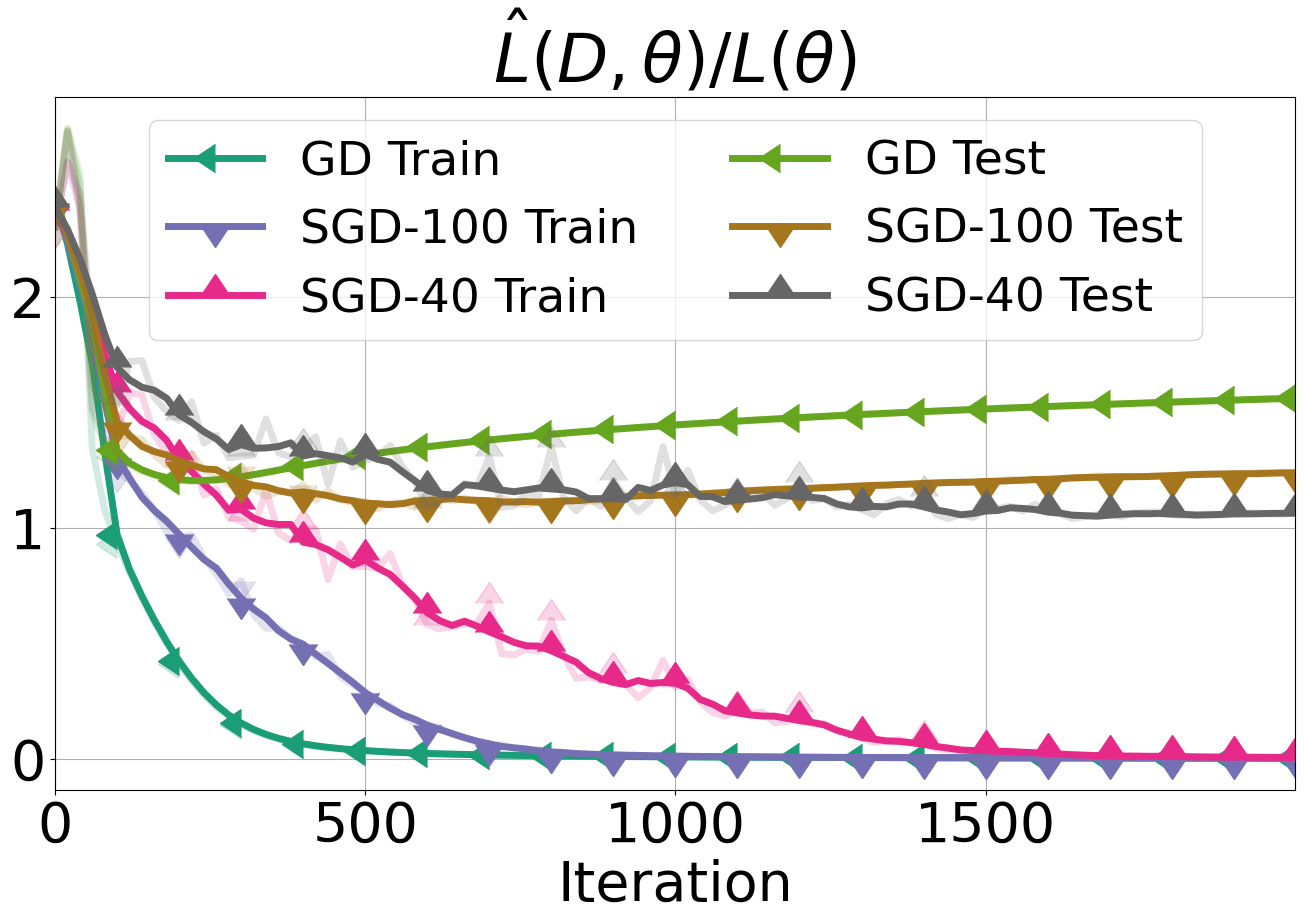

In [49]:

plt.rcParams['figure.figsize'] = (16, 9)
fontsize = 40
matplotlib.rcParams.update({'font.size': fontsize})

for i in models_id:
  plt.plot(iters_number[i], results[i][TRAIN_LOSS], alpha = 0.2,linewidth=5, color = jet(i), marker = markers[labels[i]],  markersize=20, markevery=5)
  plt.plot(iters_number[i], moving_average(results[i][TRAIN_LOSS], 5), label=labels[i]+" Train",linewidth=5,color = jet(i), marker = markers[labels[i]],  markersize=20, markevery=5)

for i in models_id:
  plt.plot(iters_number[i], results[i][TEST_LOSS], alpha = 0.2,linewidth=5, marker = markers[labels[i]], color = jet(i + len(models_id) + 1), markersize=20, markevery=5)
  plt.plot(iters_number[i], moving_average(results[i][TEST_LOSS], 5), label=labels[i]+" Test",linewidth=5,  color = jet(i + len(models_id) + 1), marker = markers[labels[i]],  markersize=20, markevery=5)

plt.xlim(0,N_ITERS-2)
plt.grid()
plt.xlabel('Iteration')

plt.legend(fontsize=50, loc = "upper center", ncol = 2,prop={'size':34})

plt.title(r"$\hat{L}(D, \theta)/L(\theta)$")
#plt.ylim(0,0.5)
plt.savefig("sgd_images/sgd_train_test.pdf", format = "pdf",bbox_inches='tight') 
plt.show()

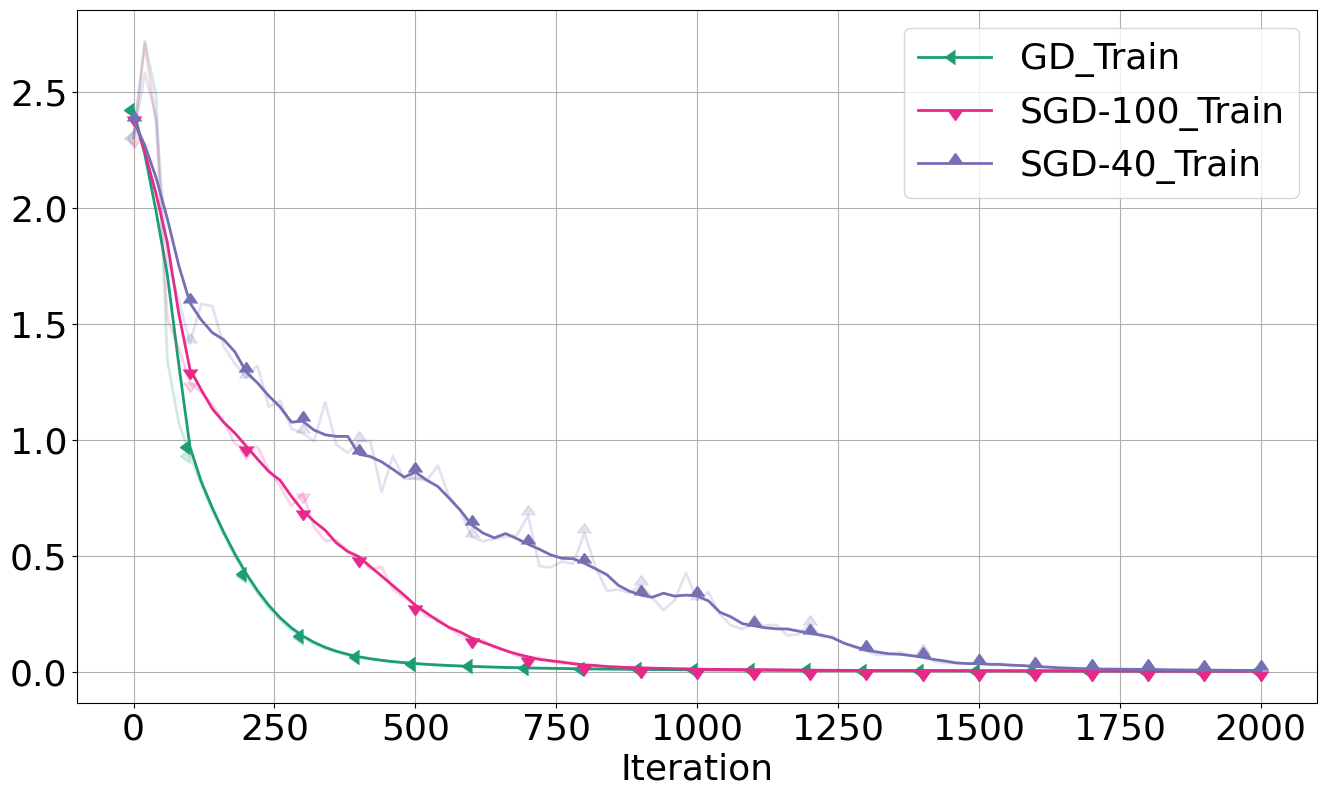

In [ ]:
for i in models_id:
  plt.plot(iters_number[i], results[i][TRAIN_LOSS], alpha = 0.2, color = colors[labels[i]],linewidth=2, marker = markers[labels[i]],  markersize=10, markevery=5)
  plt.plot(iters_number[i], moving_average(results[i][TRAIN_LOSS], 5), label=labels[i]+"_Train", color = colors[labels[i]],linewidth=2, marker = markers[labels[i]],  markersize=10, markevery=5)
#plt.ylim(0,0.5)
#plt.xlim(0,2500)
plt.grid()
plt.legend(fontsize=20, prop={'size': 26})
plt.xlabel('Iteration')

plt.savefig("sgd_images/sgd_train.pdf", format = "pdf",bbox_inches='tight') 
plt.show()

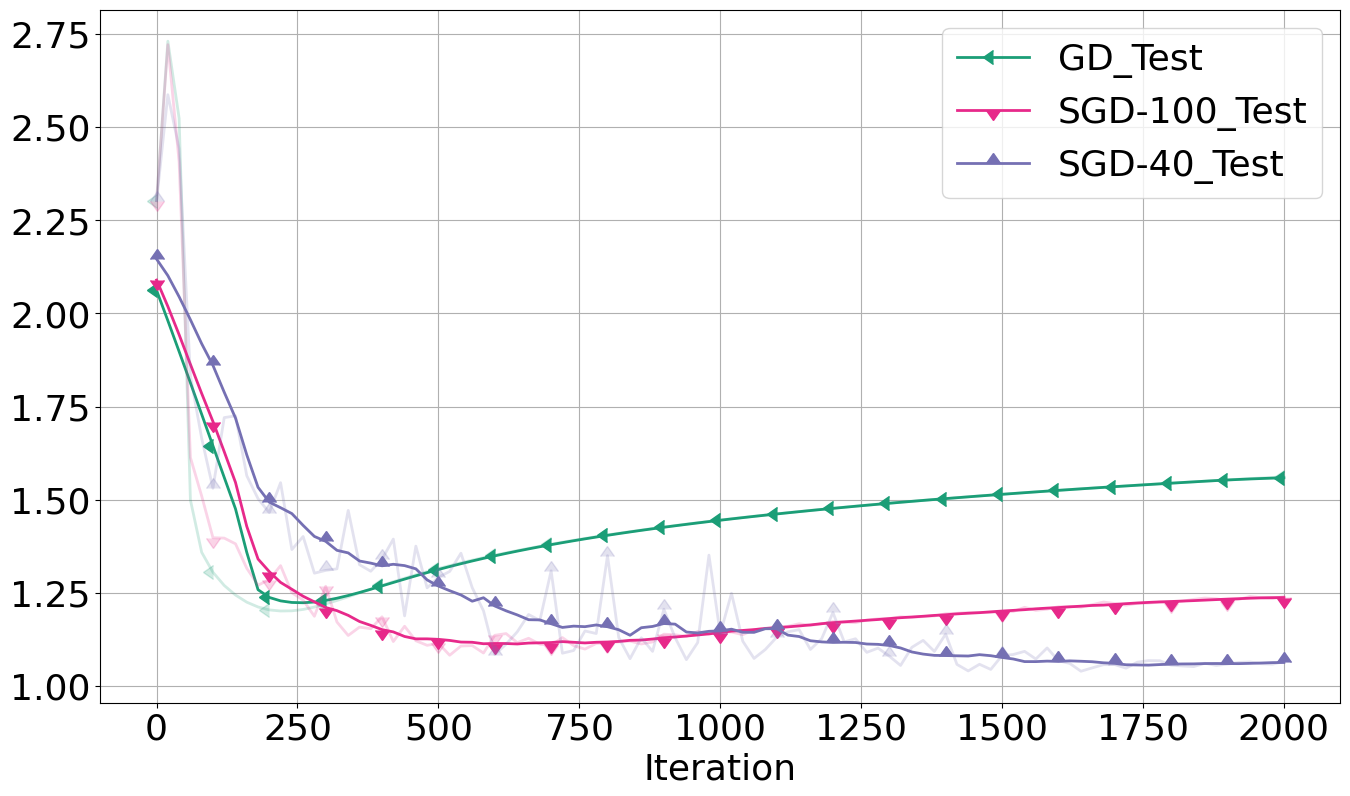

In [ ]:
for i in models_id:
  plt.plot(iters_number[i], results[i][TEST_LOSS], alpha = 0.2, color = colors[labels[i]],linewidth=2, marker = markers[labels[i]],  markersize=10, markevery=5)
  plt.plot(iters_number[i], moving_average(results[i][TEST_LOSS], 13), label=labels[i]+"_Test", color = colors[labels[i]],linewidth=2, marker = markers[labels[i]],  markersize=10, markevery=5)

#plt.ylim(0,0.5)
plt.grid()
plt.xlabel('Iteration')

plt.legend(fontsize=20, prop={'size': 26})
plt.savefig("sgd_images/sgd_test.pdf", format = "pdf",bbox_inches='tight') 
plt.show()

In [ ]:
for i in models_id:
  print(np.min(results[i][TRAIN_LOSS]))


0.002737479
0.0024156913
0.005391432


In [ ]:
for i in models_id:
  print(np.min(results[i][TEST_LOSS]))


1.2015357
1.0827521
1.0398949


# Figure 2: Inverse Rate $I^{-1}$ Evolution

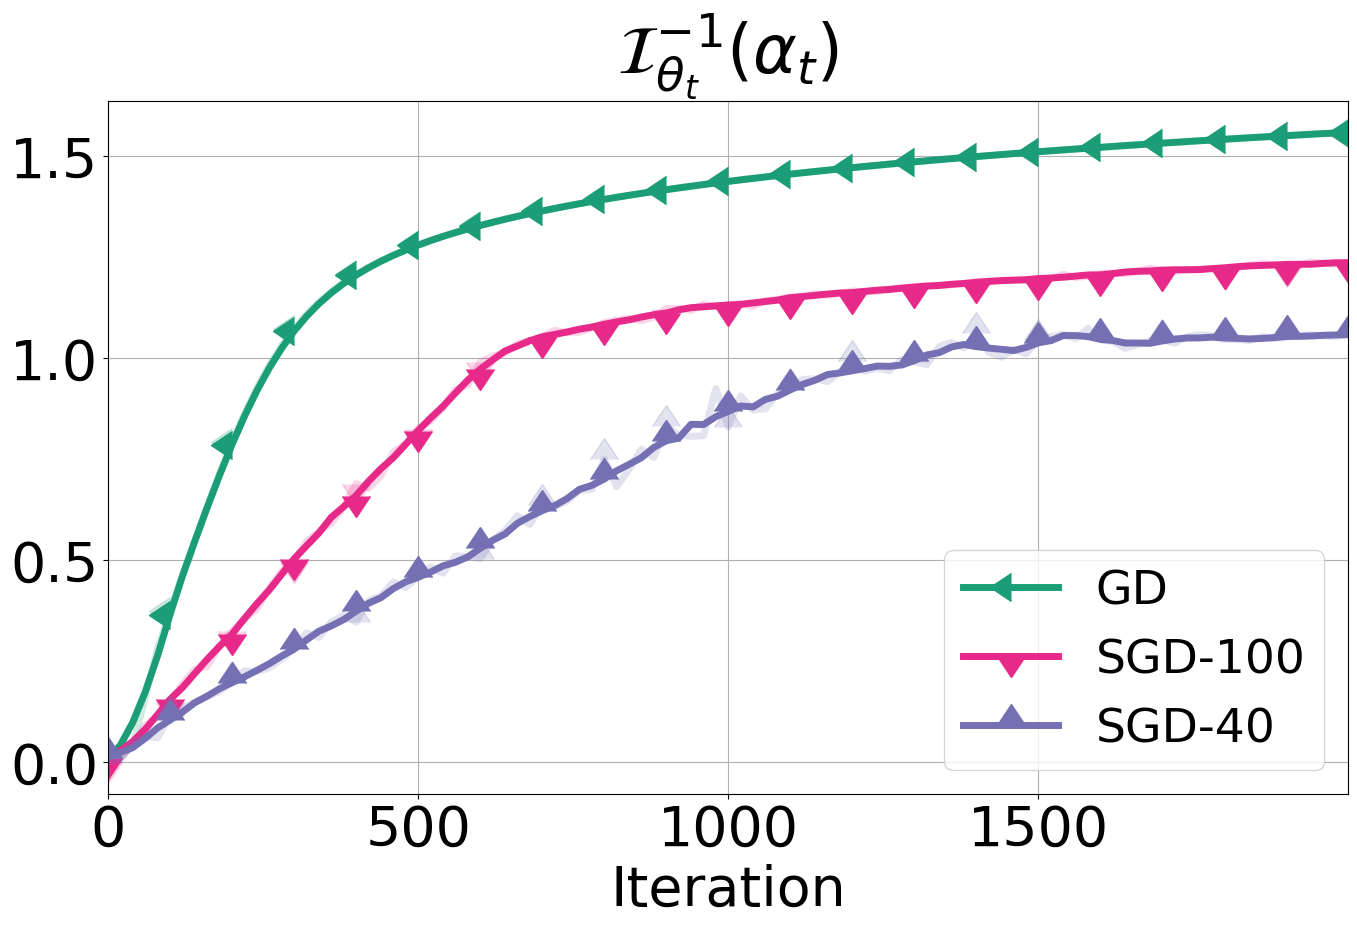

In [48]:

plt.rcParams['figure.figsize'] = (16, 9)
fontsize = 40
matplotlib.rcParams.update({'font.size': fontsize})


for i in models_id:
  a = results[i][TEST_LOSS]-results[i][TRAIN_LOSS]
  plt.plot(iters_number[i], a,  alpha = 0.2,  color = colors[labels[i]],linewidth=5, marker = markers[labels[i]],  markersize=20, markevery=5)
  plt.plot(iters_number[i], moving_average(a, 5), label=labels[i], color = colors[labels[i]],linewidth=5, marker = markers[labels[i]],  markersize=20, markevery=5)

#plt.ylim(0,0.4)
plt.grid()
plt.xlim(0,N_ITERS-2)
plt.legend(fontsize=50,prop={'size':34})

plt.xlabel('Iteration')
plt.title(r"$\mathcal{I}^{-1}_{\theta_t}(\alpha_t)$")
plt.savefig("sgd_images/sgd_inverse_rate.pdf", format = "pdf",bbox_inches='tight') 
plt.show()

# Figure 3: Variance Evolution

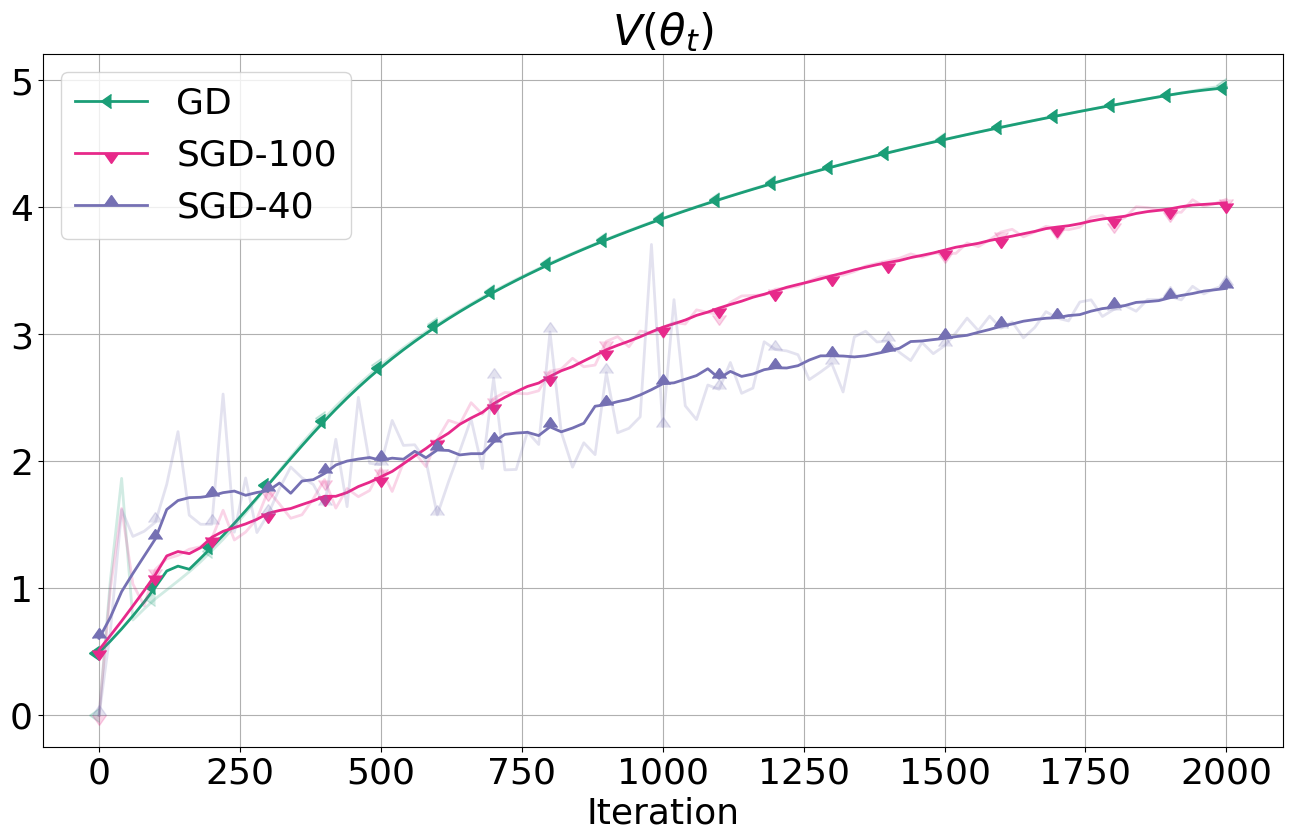

In [ ]:
for i in models_id:
  plt.plot(iters_number[i], results[i][VARIANCE], alpha = 0.2, color = colors[labels[i]],linewidth=2, marker = markers[labels[i]],  markersize=10, markevery=5)
  plt.plot(iters_number[i], moving_average(results[i][VARIANCE], 11), label=labels[i], color = colors[labels[i]],linewidth=2, marker = markers[labels[i]],  markersize=10, markevery=5)

plt.legend(fontsize=20, prop={'size': 26})
#plt.ylim(0,2.0)
plt.grid()
plt.xlabel('Iteration')

plt.title(r"$V(\theta_t)$")
plt.savefig("sgd_images/variance.pdf", format = "pdf",bbox_inches='tight') 
plt.show()

# Figure 4: Jensen-Gap Functions Evolution

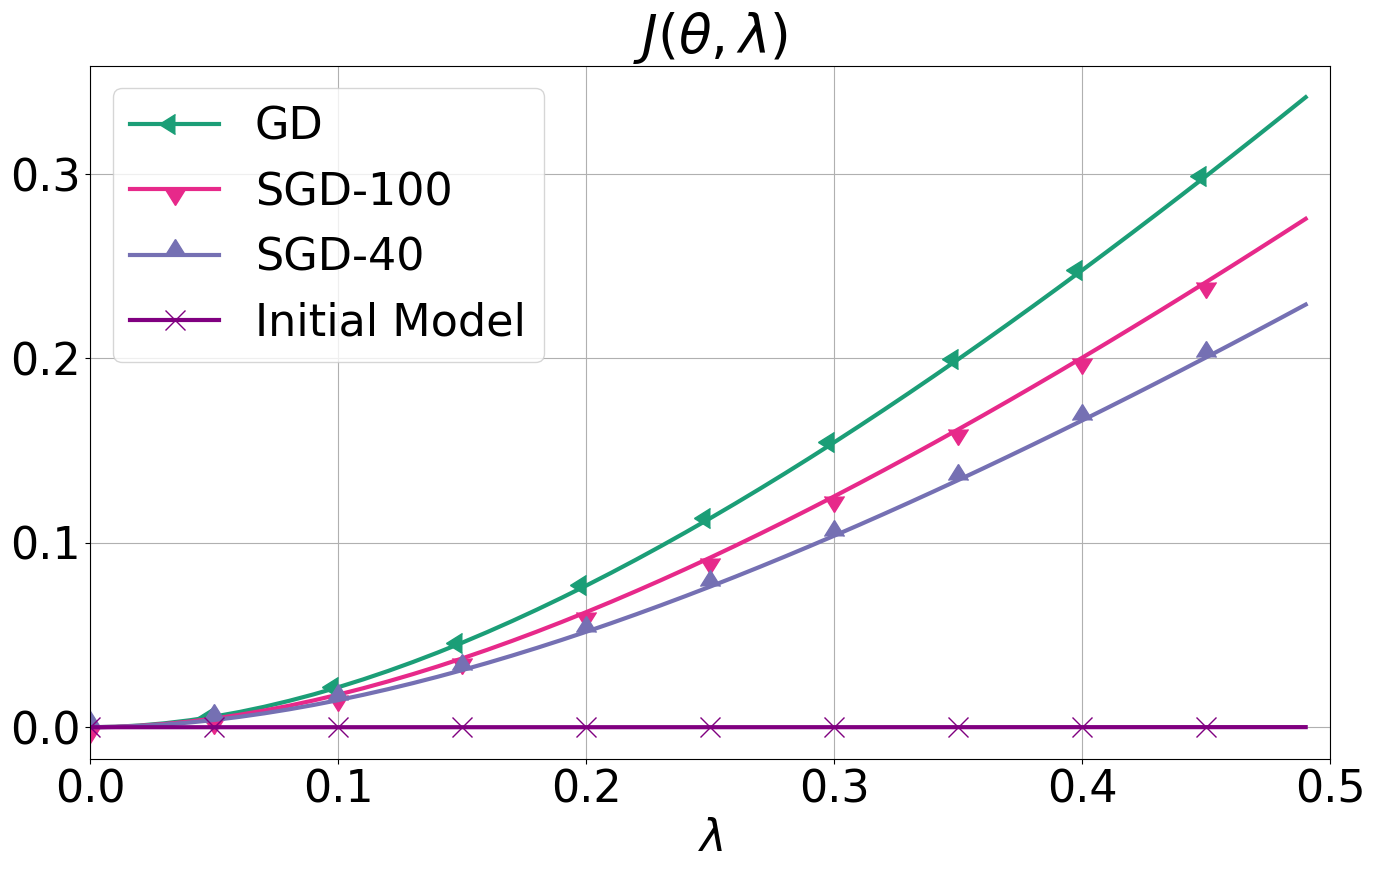

In [ ]:
lambdas = np.arange(0, 0.5, 0.01)


for i in models_id:
  jensen = eval_jensen(results[i][MODELS][-1].to(device), lambdas)
  plt.plot(lambdas, jensen, label=labels[i],linewidth=3, color = colors[labels[i]], marker = markers[labels[i]],  markersize=15, markevery=5)

jensen1 = eval_jensen(results[i][MODELS][0].to(device), lambdas)
plt.plot(lambdas, jensen1, label = "Initial Model",linewidth=3, color = "purple", marker = "x",  markersize=15, markevery=5)

plt.legend()
plt.xlim(0,0.5)
plt.xlabel(r'$\lambda$')

plt.grid()
plt.title(r"$J(\theta,\lambda)$")
plt.savefig("sgd_images/jensen.pdf", format = "pdf",bbox_inches='tight') 
plt.show()

In [34]:
rates = []
s_values = np.arange(0, 0.5, 0.01)

for i in models_id:
  print(i)
  rates.append(np.array([rate_function_BS(results[i][MODELS][-1].to(device), s)[0] for s in s_values]))

rate_initial = np.array([rate_function_BS(results[i][MODELS][0].to(device), s)[0] for s in s_values])

0
2
3


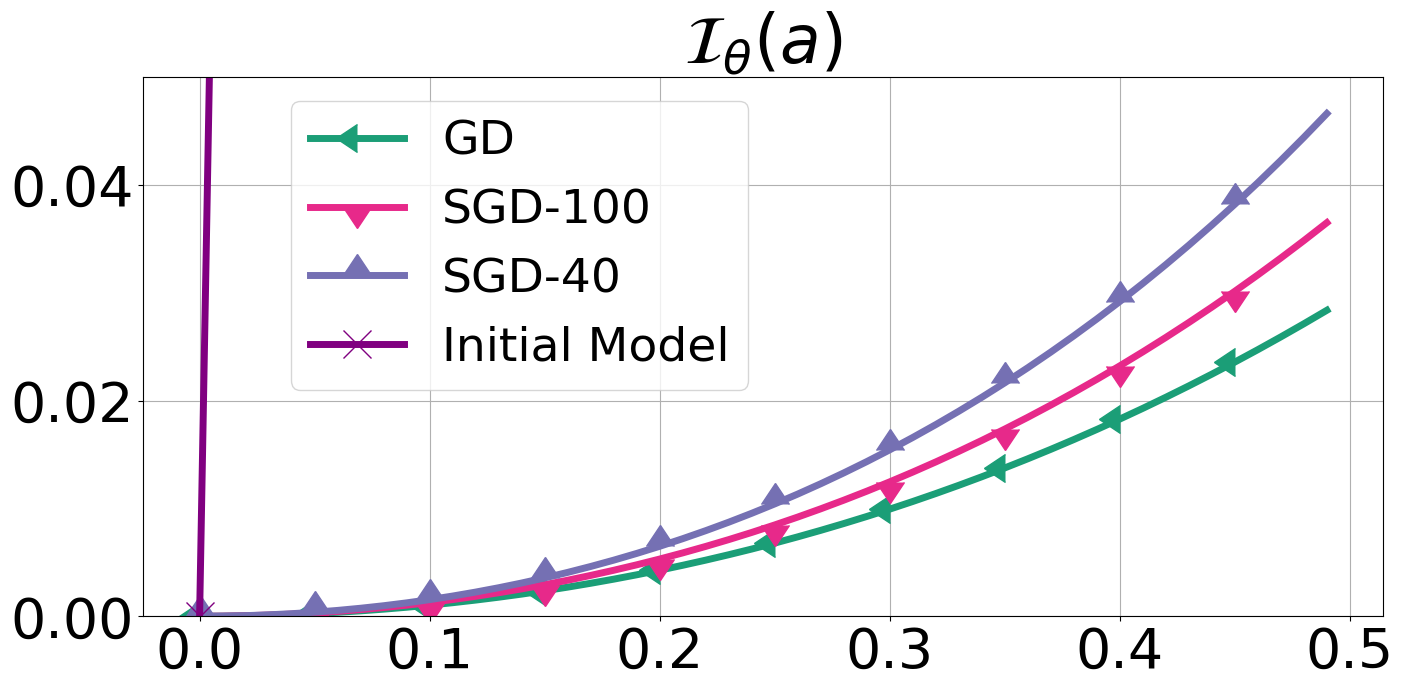

In [40]:

plt.rcParams['figure.figsize'] = (16, 7)
fontsize = 40
matplotlib.rcParams.update({'font.size': fontsize})

for idx, i in enumerate(models_id):
  plt.plot(s_values, rates[idx], label=labels[i],linewidth=5, color = colors[labels[i]], marker = markers[labels[i]],  markersize=20, markevery=5)

plt.plot(s_values, rate_initial, label = "Initial Model",linewidth=5, color = "purple", marker = "x",  markersize=20, markevery=5)
plt.legend(fontsize=50,bbox_to_anchor=(0.1, 1), prop={'size':34})
#plt.legend(fontsize=28, bbox_to_anchor=(0.1, 1), prop={'size':35})
plt.ylim(0, 0.05)
plt.grid()
plt.title(r"$\mathcal{I}_{\theta}(a)$")
plt.savefig("sgd_images/rate.pdf", format = "pdf",bbox_inches='tight') 
plt.show()

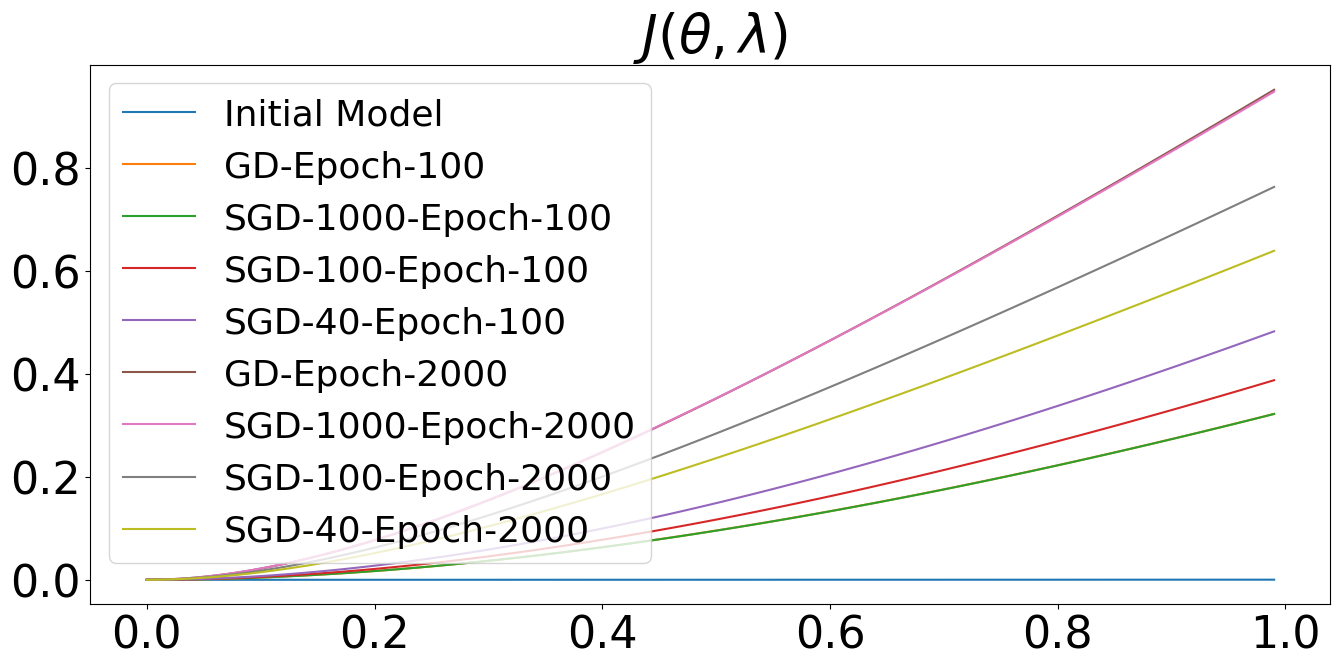

In [36]:
# Computing m_\theta
lambdas = np.arange(0, 1, 0.01)


jensen1 = eval_jensen(results[i][MODELS][0], lambdas)
plt.plot(lambdas, jensen1, label = "Initial Model")

index = [100,N_ITERS-1]
cont=0
for j in index:
  for i in range(len(models)):
    jensen1 = eval_jensen(results[i][MODELS][int(j/n_evals[i])].to(device), lambdas)
    plt.plot(lambdas, jensen1, label = labels[i]+"-Epoch-"+str(j))

#plt.ylim(-0.5,7)
plt.legend(fontsize=20, prop={'size': 26})
plt.title(r"$J(\theta,\lambda)$")
plt.savefig("sgd_images/jensen_epochs.pdf", format = "pdf",bbox_inches='tight') 
plt.show()

# Figure 5: Rates Evolution



Compute Rates

In [ ]:
for i in range(3, 4):
  setting_name=f"rs_{RANDOM_SEED}_{model_name}_{labels[i]}_lr_{LEARNING_RATE}_trainsize_{SUBSET_SIZE}_testsize_{TEST_SUBSET_SIZE}_niters_{N_ITERS}_batchsize_{batches[i]}_wd_{weight_decay}" 
  rates = []
  for j in tqdm(range(len(results[i][TEST_LOSS]))):
    rates.append(rate_function_BS(results[i][MODELS][j].to(device), results[i][TEST_LOSS][j] - results[i][BATCH_LOSS][j]))
  with open(f'sgd_images/{setting_name}_rates.pickle', 'wb') as handle:
    pickle.dump(rates, handle, protocol=pickle.HIGHEST_PROTOCOL)

Load and Figures

In [51]:
rates = []

for i in range(len(models)):
  setting_name=f"rs_{RANDOM_SEED}_{model_name}_{labels[i]}_lr_{LEARNING_RATE}_trainsize_{SUBSET_SIZE}_testsize_{TEST_SUBSET_SIZE}_niters_{N_ITERS}_batchsize_{batches[i]}_wd_{weight_decay}" 
  with open(f"sgd_images/{setting_name}_rates.pickle", "rb") as handle:
    rates.append(pickle.load(handle))

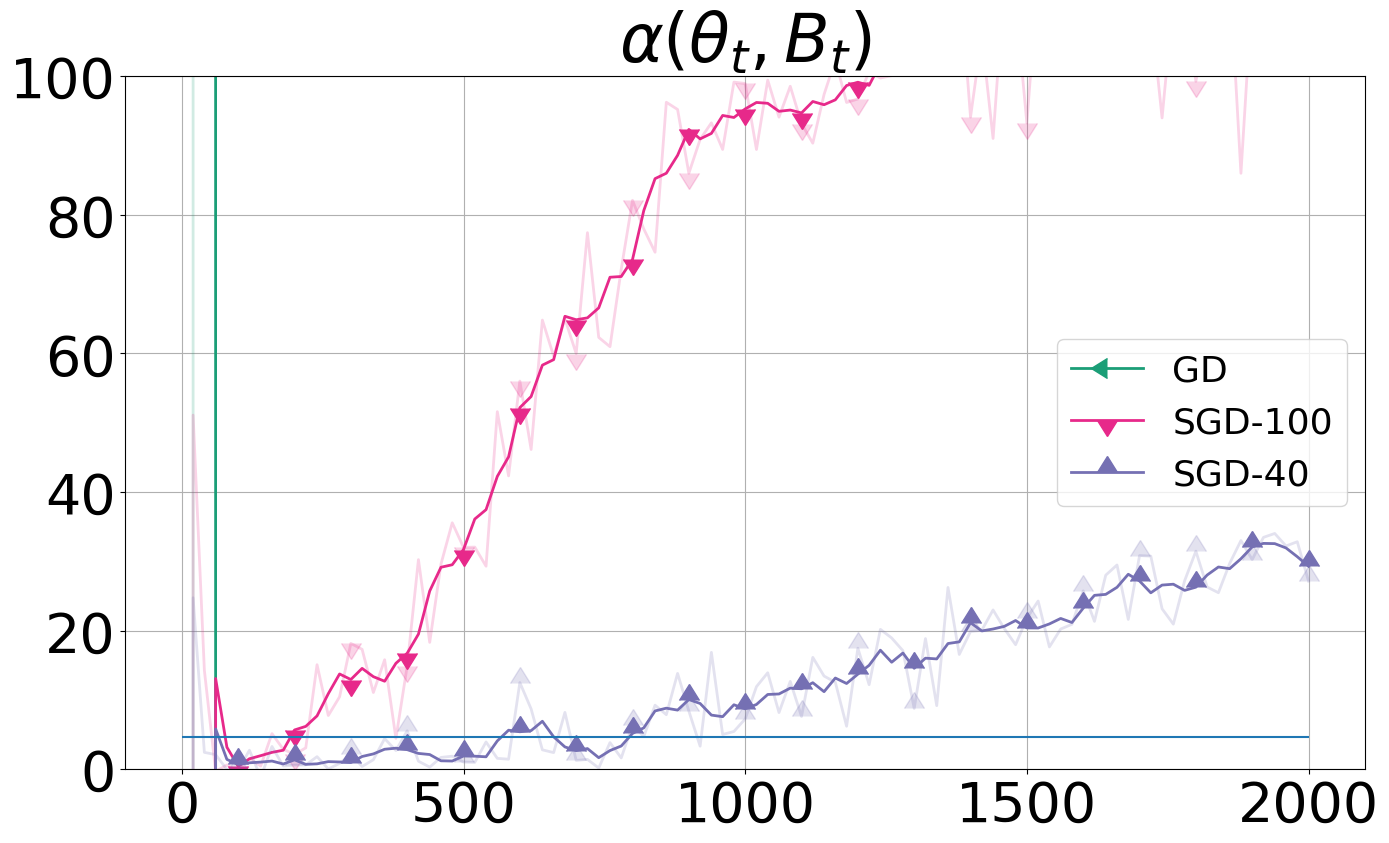

In [52]:
for i in models_id:
  a = [np.sign(results[i][TEST_LOSS][j] - results[i][BATCH_LOSS][j])*rates[i][j][0]*batches[i] for j in range(len(rates[i]))]
  plt.plot(iters_number[i], a, alpha = 0.2, color = colors[labels[i]],linewidth=2, marker = markers[labels[i]],  markersize=15, markevery=5)
  plt.plot(iters_number[i], moving_average(a, 5), label=labels[i],  color = colors[labels[i]],linewidth=2, marker = markers[labels[i]],  markersize=15, markevery=5)

plt.legend(fontsize=20, prop={'size': 26})
#plt.xlim(100,2500)
plt.ylim(0, 100)
plt.grid()
plt.hlines(np.log(1/0.01),0,N_ITERS)
plt.title(r"$\alpha(\theta_t,B_t)$")
plt.savefig("sgd_images/rates.pdf", format = "pdf",bbox_inches='tight') 
plt.show()


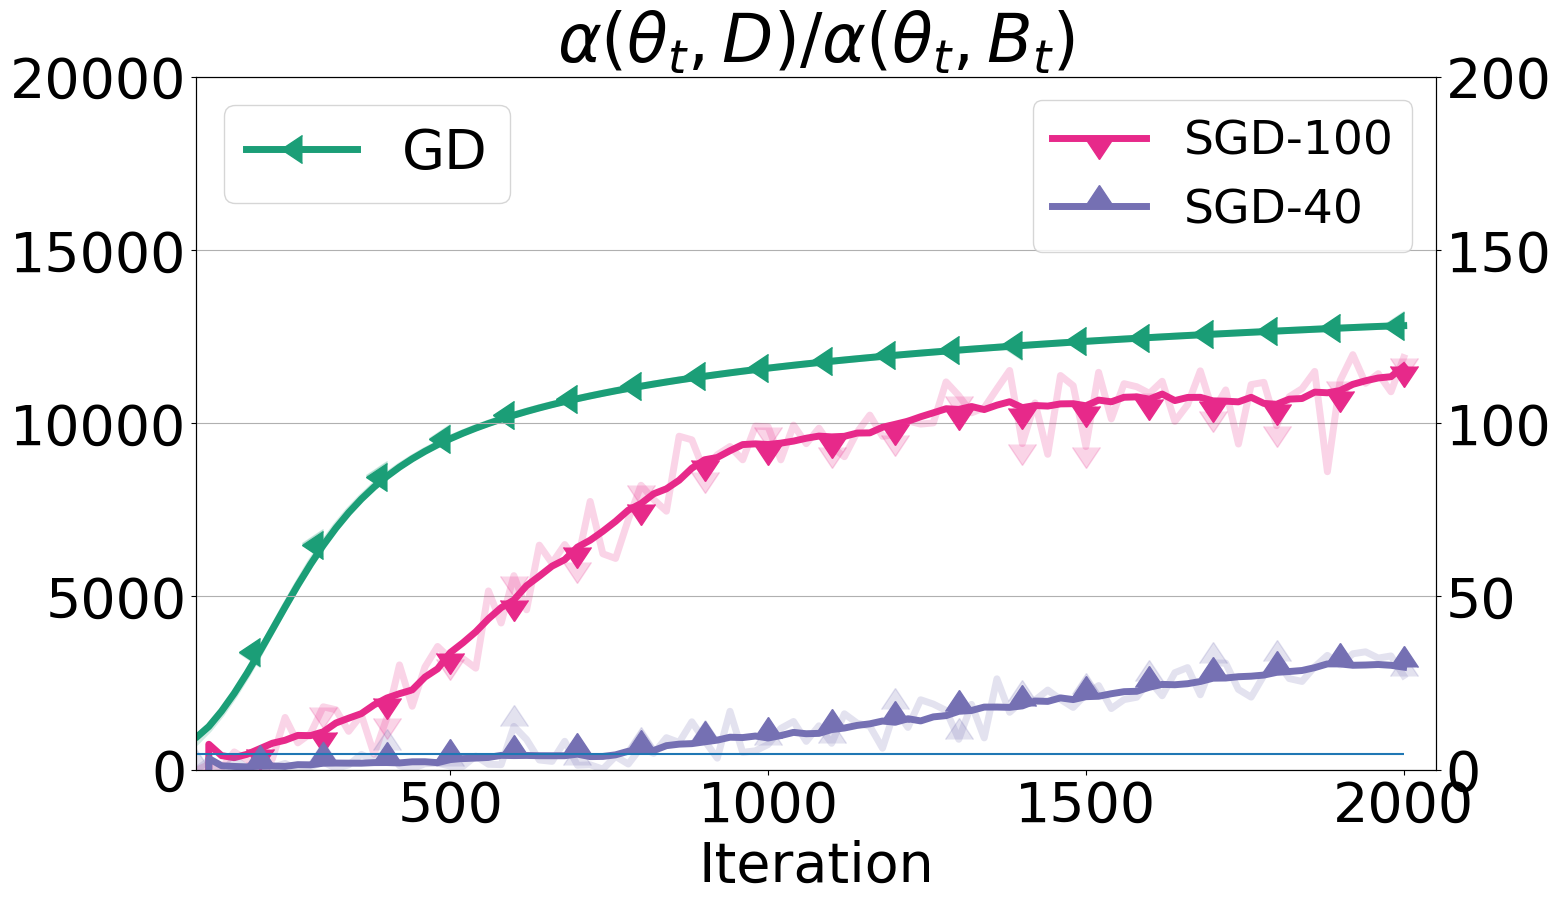

In [54]:

plt.rcParams['figure.figsize'] = (16, 9)
fontsize = 40
matplotlib.rcParams.update({'font.size': fontsize})

# create the first plot
fig, ax1 = plt.subplots()
i=0
offset = 0
a = [np.sign(results[i][TEST_LOSS][j] - results[i][BATCH_LOSS][j])*rates[i][j][0]*batches[i] for j in range(len(rates[i]))][offset:]
ax1.plot(iters_number[i][offset:], a, alpha = 0.2, color = colors[labels[i]],linewidth=5, marker = markers[labels[i]],  markersize=20, markevery=5)
ax1.plot(iters_number[i][offset:], moving_average(a, 5), label=labels[i], color = colors[labels[i]],linewidth=5, marker = markers[labels[i]],  markersize=20, markevery=5)


ax1.set_xlabel('Iteration')
ax1.set_xlim(100,N_ITERS+50)
ax1.set_ylim(0, 20000)
#ax1.tick_params('y', colors='g')
plt.legend(loc = "upper left")

# create the second plot
ax2 = ax1.twinx()
for i in range(2,len(models)):
  a = [np.sign(results[i][TEST_LOSS][j] - results[i][BATCH_LOSS][j])*rates[i][j][0]*batches[i] for j in range(len(rates[i]))]
  ax2.plot(iters_number[i], a, alpha = 0.2, color = colors[labels[i]],linewidth=5, marker = markers[labels[i]],  markersize=20, markevery=5)
  ax2.plot(iters_number[i], moving_average(a, 11),label=labels[i], color = colors[labels[i]],linewidth=5, marker = markers[labels[i]],  markersize=20, markevery=5)
ax2.set_ylim(0, 200)
ax2.set_xlim(100,N_ITERS+50)
plt.legend(fontsize=50, prop={'size':34})

plt.grid()
plt.hlines(np.log(1/0.01),0,N_ITERS)
plt.title(r"$\alpha(\theta_t,D)/\alpha(\theta_t,B_t)$")
plt.savefig("sgd_images/rates.pdf", format = "pdf",bbox_inches='tight') 
plt.show()

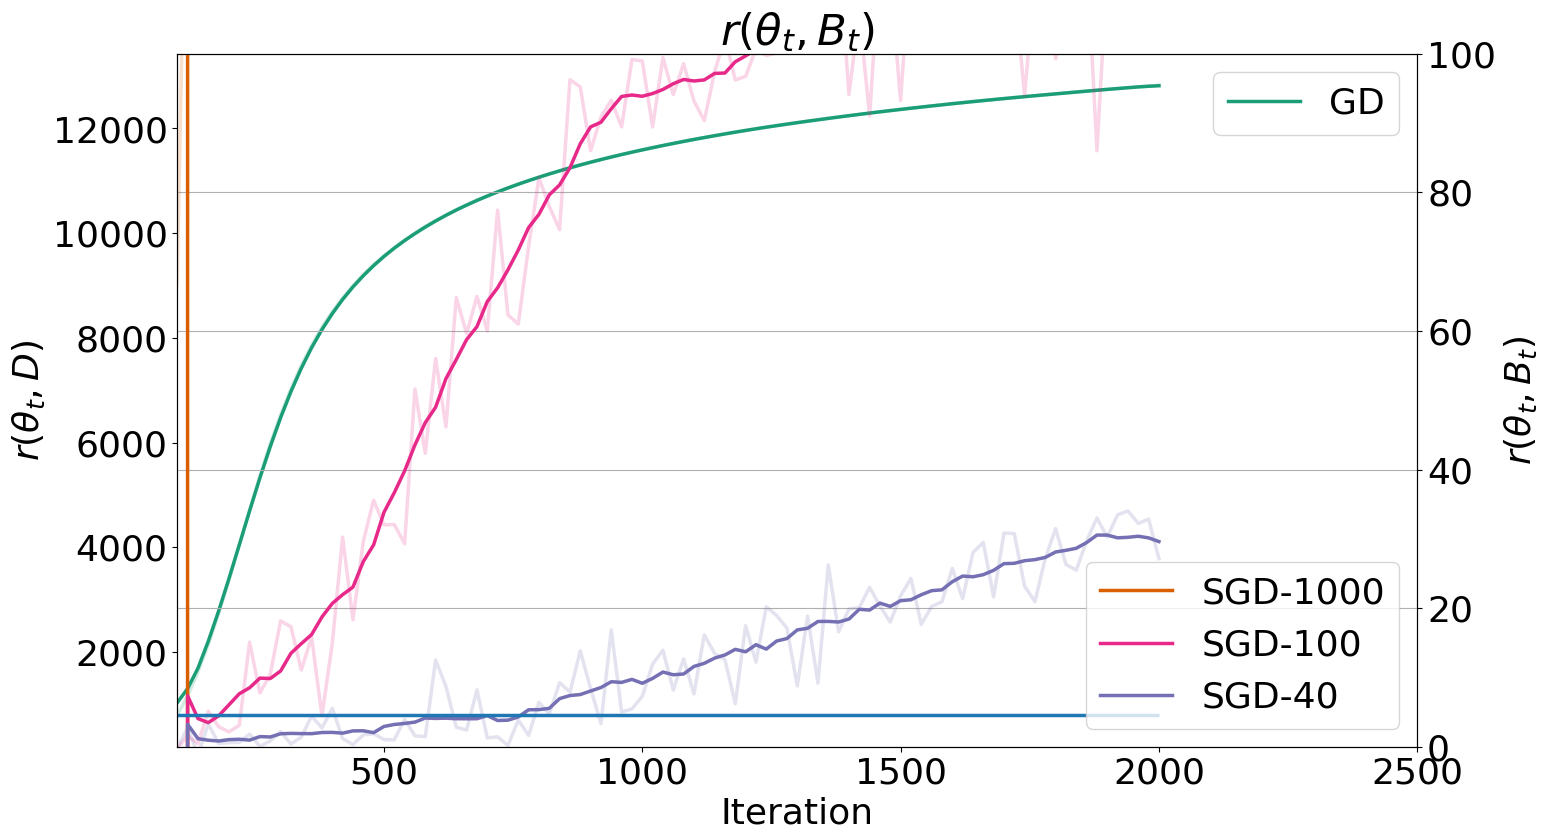

In [ ]:
# create the first plot
fig, ax1 = plt.subplots()
i=0
offset = 5
a = [np.sign(results[i][TEST_LOSS][j] - results[i][BATCH_LOSS][j])*rates[i][j][0]*batches[i] for j in range(len(rates[i]))][offset:]
ax1.plot(iters_number[i][offset:], a, alpha = 0.2, color = colors[labels[i]],linewidth=2.5)
ax1.plot(iters_number[i][offset:], moving_average(a, 5), label=labels[i], color = colors[labels[i]],linewidth=2.5)
ax1.set_xlabel('Iteration')
ax1.set_xlim(100,2500)
#ax1.set_ylim(-30,300)
ax1.set_ylabel(r'$r(\theta_t,D)$')
#ax1.tick_params('y', colors='g')
plt.legend(fontsize=20, prop={'size': 26})

# create the second plot
ax2 = ax1.twinx()
for i in range(1,len(models)):
  a = [np.sign(results[i][TEST_LOSS][j] - results[i][BATCH_LOSS][j])*rates[i][j][0]*batches[i] for j in range(len(rates[i]))]
  ax2.plot(iters_number[i], a, alpha = 0.2, color = colors[labels[i]],linewidth=2.5)
  ax2.plot(iters_number[i], moving_average(a, 11),label=labels[i], color = colors[labels[i]],linewidth=2.5)

ax2.set_ylim(0, 100)
ax2.set_xlim(100,2500)
ax2.set_ylabel(r'$r(\theta_t,B_t)$')
plt.legend(fontsize=20, prop={'size': 26})


# show the plot
plt.title(r"$r(\theta_t,B_t)$")
plt.grid()
plt.hlines(np.log(1/0.01),0,N_ITERS,linewidth=2.5)

plt.savefig("sgd_images/rates_two_axes.pdf", format = "pdf",bbox_inches='tight')
plt.show()



In [ ]:
np.log(1/0.01)


# Figure 6: KLs Evolution





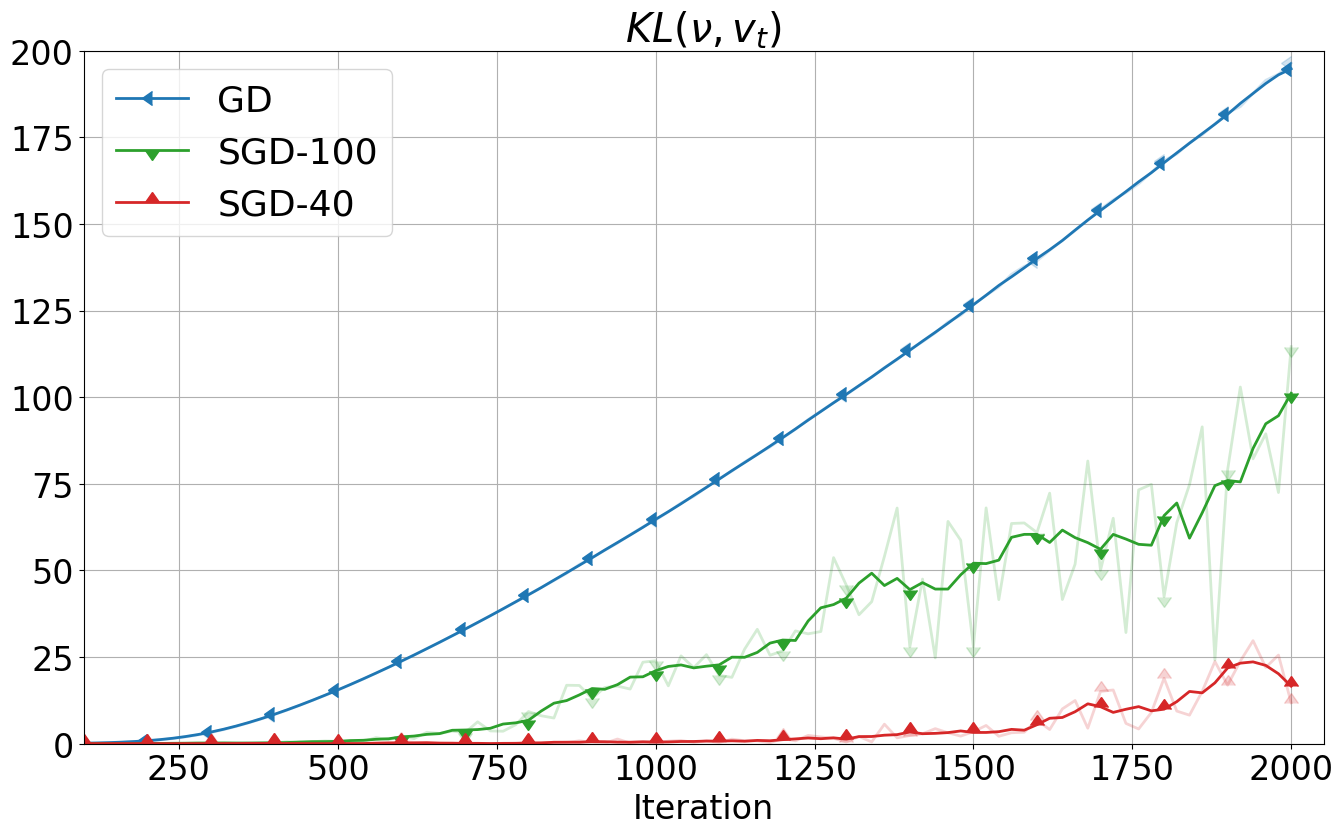

In [ ]:
for i in models_id:
  vec = [rates[i][j][2] for j in range(len(rates[i]))]
  plt.plot(iters_number[i], vec, alpha = 0.2, color = colors[labels[i]],linewidth=2, marker = markers[labels[i]],  markersize=10, markevery=5)
  plt.plot(iters_number[i], moving_average(vec, 5), label=labels[i], color = colors[labels[i]],linewidth=2, marker = markers[labels[i]],  markersize=10, markevery=5)

plt.legend(fontsize=20, prop={'size': 26})
plt.ylim(0,200)
plt.xlim(100,N_ITERS+50)
#plt.xlim(0,250)
plt.xlabel('Iteration')

plt.title(r"$KL(\nu, v_t)$")
plt.grid()
plt.savefig("sgd_images/KL.pdf", format = "pdf",bbox_inches='tight') 
plt.show()

In [ ]:
for i in models_id:
  vec = [np.sign(results[i][TEST_LOSS][j] - results[i][BATCH_LOSS][j])*rates[i][j][0]*batches[i] for j in range(len(rates[i]))]
  plt.hist(vec,density=True)
  # Plot density
  lambda_rate=1
  x = np.linspace(0, np.log(1.0/0.01)/lambda_rate, 1000)
  y = lambda_rate *np.exp(-lambda_rate * x)
  plt.plot(x, y, color='red')
  plt.plot(-x, y, color='red')
  plt.savefig(f"sgd_images/hist_{labels[i]}.pdf", format = "pdf",bbox_inches='tight') 
  plt.show()


In [ ]:
#Acceptance rate
for i in range(len(models)):
  vec = np.array([rates[i][j][0]*batches[i] for j in range(len(rates[i]))])
  print(np.mean(np.random.uniform(0,1,vec.shape[0])<np.exp(-vec)))

# Figure 7: Rates Limit

In [ ]:
#rates_batch_lim = []
#for i in range(len(models)):
#  rates_batch_lim.append([rate_function_BS(results[i][MODELS][j], results[i][TEST_LOSS][j] - 0.01)[0] for j in tqdm(range(len(results[i][MODELS])))])


In [ ]:
#with open(f'sgd_images/{setting_name}_rates_lim.pickle', 'wb') as handle:
#  pickle.dump(rates_batch_lim, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#with open(f"sgd_images/{setting_name}_rates_lim.pickle", "rb") as handle:
#  rates_batch_lim = pickle.load(handle)

In [ ]:
#for i in models_id:
#  plt.plot(iters_number, np.array(rates_batch_lim[i]), label=labels[i])
#  plt.plot(iters_number, [np.sign(results[i][TEST_LOSS][j] - results[i][BATCH_LOSS][j])*rates[i][j][0]*batches[i] for j in range(len(rates[i]))], label=labels[i])

#plt.legend()
#plt.grid()
#plt.ylim(0,1)
#plt.xlim(0,N_ITERS)
#plt.title("Rate Lim-0.01")


# Download Files

In [ ]:
!zip sgd_images/images.zip sgd_images/*.pdf

updating: sgd_images/jensen_epochs.pdf (deflated 9%)
updating: sgd_images/jensen.pdf (deflated 15%)
updating: sgd_images/KL.pdf (deflated 14%)
updating: sgd_images/rates.pdf (deflated 14%)
updating: sgd_images/rates_two_axes.pdf (deflated 5%)
updating: sgd_images/sgd_inverse_rate.pdf (deflated 14%)
updating: sgd_images/sgd_test.pdf (deflated 12%)
updating: sgd_images/sgd_train.pdf (deflated 13%)
updating: sgd_images/sgd_train_test.pdf (deflated 13%)
updating: sgd_images/variance.pdf (deflated 14%)
updating: sgd_images/hist_GD.pdf (deflated 16%)
updating: sgd_images/hist_SGD-L2.pdf (deflated 16%)
updating: sgd_images/hist_SGD.pdf (deflated 16%)
updating: sgd_images/hist_SGD-R1.pdf (deflated 16%)
updating: sgd_images/hist_SGD-R2.pdf (deflated 16%)


In [ ]:
files.download('sgd_images/images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls -l sgd_images

total 17134420
-rw-r--r-- 1 root root        7294 Apr 23 13:51 hist_GD.pdf
-rw-r--r-- 1 root root        7220 Apr 23 13:51 hist_SGD-L2.pdf
-rw-r--r-- 1 root root        7216 Apr 23 13:51 hist_SGD.pdf
-rw-r--r-- 1 root root        7222 Apr 23 13:51 hist_SGD-R1.pdf
-rw-r--r-- 1 root root        7223 Apr 23 13:51 hist_SGD-R2.pdf
-rw-r--r-- 1 root root      225511 Apr 26 19:09 images.zip
-rw-r--r-- 1 root root       21087 Apr 25 16:07 jensen_epochs.pdf
-rw-r--r-- 1 root root       16421 Apr 26 19:00 jensen.pdf
-rw-r--r-- 1 root root       21344 Apr 26 19:02 KL.pdf
-rw-r--r-- 1 root root       21484 Apr 26 19:02 rates.pdf
-rw-r--r-- 1 root root       37462 Apr 23 14:07 rates_two_axes.pdf
-rw-r--r-- 1 root root   574527215 Apr 24 16:54 rs_214748365_alexnet_GD_lr_0.001_trainsize_8000_testsize_10000_niters_2001_batchsize_8000_wd_0.1_results.pickle
-rw-r--r-- 1 root root   574527227 Apr 24 17:09 rs_214748365_alexnet_SGD-1000_lr_0.001_trainsize_8000_testsize_10000_niters_2001_batchsize_1000_wd_0